In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from scipy.stats import skew
from utils import computeBoundaries, plot_and_segment_cube_signals

def clustering_and_plotting(base_path, cube_numbers, excel_path='./experiment_parameters.xlsx', N=1, plot_segmentation=False):
    # Load parameters from Excel into a dictionary
    xl = pd.ExcelFile(excel_path)
    params_dict = {sheet_name: xl.parse(sheet_name)[['Speed (mm/s)', 'Power (W)', 'Power perc (%)']].to_dict('records') for sheet_name in xl.sheet_names}
    
    # Initialize the dictionary to hold the segmented data tensors
    segmented_data_dict = {}
    
    for cube_number in cube_numbers:
        print(f'Working on cube {cube_number}')
        plot_and_segment_cube_signals(base_path, params_dict, cube_number, segmented_data_dict, threshold=0.1, plot_signals=plot_segmentation)
        print('---' * 10)
    
    def extract_features(data):
        features = {}
        
        data_emission = np.mean(data[:, 0, :], axis=0)
        features['mean_emission'] = np.mean(data_emission, axis=0)
        features['std_emission'] = np.std(data_emission, axis=0)
        features['median_emission'] = np.median(data_emission, axis=0)
        features['95th_percentile_emission'] = np.percentile(data_emission, 95, axis=0)
        features['5th_percentile_emission'] = np.percentile(data_emission, 5, axis=0)
        features['skewness_emission'] = skew(data_emission, axis=0)
        
        data_reflection = np.mean(data[:, 1, :], axis=0)
        features['mean_reflection'] = np.mean(data_reflection, axis=0)
        features['std_reflection'] = np.std(data_reflection, axis=0)
        features['median_reflection'] = np.median(data_reflection, axis=0)
        features['95th_percentile_reflection'] = np.percentile(data_reflection, 95, axis=0)
        features['5th_percentile_reflection'] = np.percentile(data_reflection, 5, axis=0)
        features['skewness_reflection'] = skew(data_reflection, axis=0)
        
        return features
    
    features_list = []
    label_list = []
    powers = []
    speeds = []

    for key, value in segmented_data_dict.items():
        power, speed, _ = key
        extracted_features = extract_features(value)
        feats = [v for k, v in extracted_features.items()]
        
        features_list.append(np.reshape(feats, (1, len(feats))))
        label_list.append((power, speed))
        powers.append(power)
        speeds.append(speed)

    all_data = []
    for single_power in set(powers):
        single_power_data = { (speed, power): val for (power, speed), val in zip(label_list, features_list) if power == single_power }
        if single_power_data:
            all_data.append(single_power_data)

    clustering_algorithms = {
        'KMeans': KMeans(n_clusters=2, random_state=0),
        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=2),
        'SpectralClustering': SpectralClustering(n_clusters=2)
    }

    def prepare_data_for_clustering(data, max_speeds, max_powers):
        to_be_clustered = []
        for k, v in data.items():
            speed, power = k
            num_rows = v.shape[0]
            
            speed_column = np.full((num_rows, 1), speed / max_speeds)
            power_column = np.full((num_rows, 1), power / max_powers)
            
            extended_v = np.hstack((v, speed_column, power_column))
            to_be_clustered.append(extended_v)
        
        X = np.vstack(to_be_clustered)
        X = X[X[:, -2].argsort()]
        
        return X

    def main(all_data, N):
        max_speeds = max([max(k[0] for k in data.keys()) for data in all_data])
        max_powers = max([max(k[1] for k in data.keys()) for data in all_data])
        
        for algo_name, algorithm in clustering_algorithms.items():
            all_labels = []
            all_X = []
            
            for i in range(len(all_data)):
                data = all_data[i]
                X = prepare_data_for_clustering(data, max_speeds, max_powers)

                print(f"Working with data index {i} for algorithm {algo_name}")

                # Fit the clustering algorithm and predict cluster labels
                if algo_name in ['DBSCAN', 'SpectralClustering']:
                    labels = algorithm.fit_predict(X)
                else:
                    algorithm.fit(X)
                    labels = algorithm.labels_
                
                # Adjust labels to ensure consistency (keyhole = 1, conduction = 0)
                if labels[0] != 1: 
                    labels = 1 - labels

                all_labels.extend(labels)
                all_X.extend(X)

            all_labels = np.array(all_labels)
            all_X = np.array(all_X)
            
            # Define colors for the clusters
            colors = np.where(all_labels == 1, 'red', 'green')

            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(all_X[:, -2] * max_speeds, all_X[:, -1] * max_powers, 
                                  c=colors)

            # Custom legend entries
            plt.scatter([], [], c='red', label='Keyhole')
            plt.scatter([], [], c='green', label='Conduction')

            plt.legend(loc='lower right', bbox_to_anchor=(1, 0.2))
            plt.title(f'Clustering results for all powers ({algo_name})')
            plt.xlabel('Speed (mm/s)')
            plt.ylabel('Power (W)')
            plt.grid()
            
            # Set x and y limits
            plt.xlim(80, max_speeds * 1.1)
            plt.ylim(80, 130)
        
            plt.show()

    main(all_data, N)


Working on cube 1
Condition 1: Found 10 segments, Avg. Size: 2250.40, Std. Dev: 36.45
Segment Max Size: 2332, Segment Min Size: 2213
Condition 2: Found 10 segments, Avg. Size: 2797.50, Std. Dev: 1.96
Segment Max Size: 2801, Segment Min Size: 2795
Condition 3: Found 10 segments, Avg. Size: 1408.60, Std. Dev: 0.80
Segment Max Size: 1410, Segment Min Size: 1407
Condition 4: Found 10 segments, Avg. Size: 1836.80, Std. Dev: 1.33
Segment Max Size: 1839, Segment Min Size: 1835
Condition 5: Found 10 segments, Avg. Size: 3641.70, Std. Dev: 8.43
Segment Max Size: 3661, Segment Min Size: 3636
Condition 6: Found 10 segments, Avg. Size: 2498.80, Std. Dev: 0.87
Segment Max Size: 2500, Segment Min Size: 2498
Condition 7: Found 10 segments, Avg. Size: 1535.40, Std. Dev: 0.66
Segment Max Size: 1537, Segment Min Size: 1535
Condition 8: Found 10 segments, Avg. Size: 1902.30, Std. Dev: 0.46
Segment Max Size: 1903, Segment Min Size: 1902
Condition 9: Found 10 segments, Avg. Size: 1287.20, Std. Dev: 0.60
Se

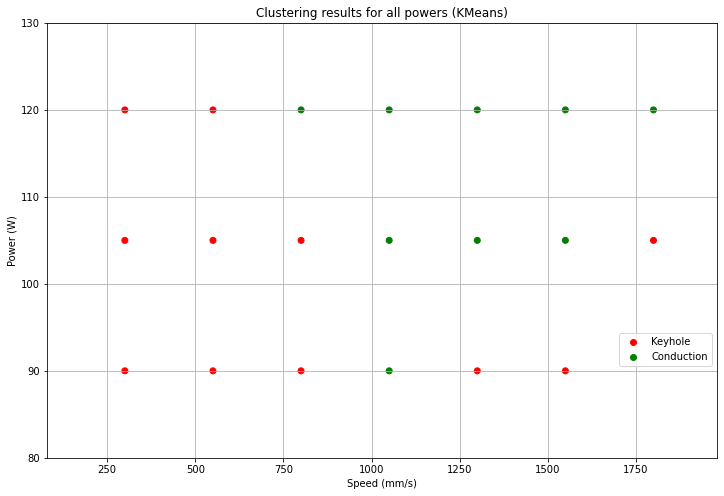

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


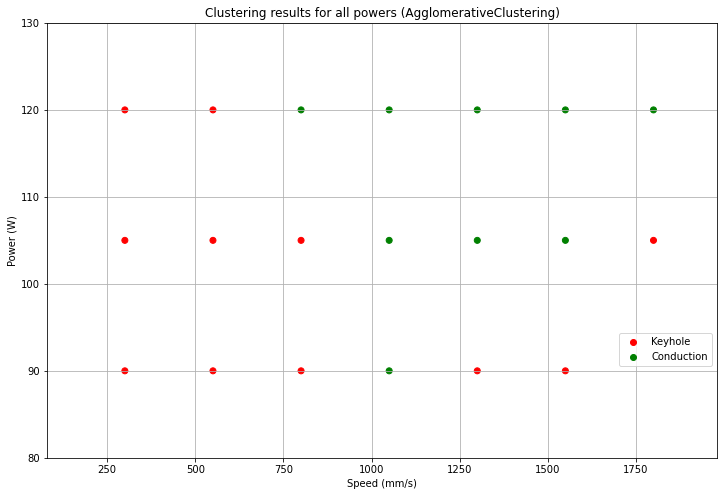

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


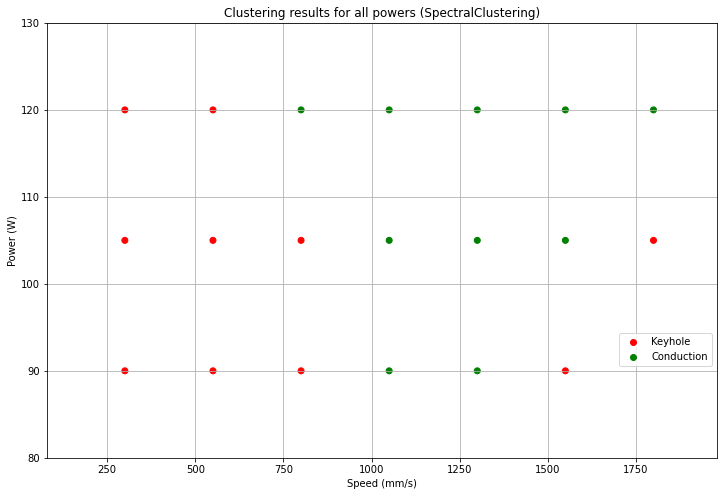

In [2]:
clustering_and_plotting('./Data/Neuchatel_316L/', [1, 2])


Working on cube 3
Condition 1: Found 10 segments, Avg. Size: 1284.90, Std. Dev: 8.32
Segment Max Size: 1289, Segment Min Size: 1260
Condition 2: Found 10 segments, Avg. Size: 1537.30, Std. Dev: 0.90
Segment Max Size: 1539, Segment Min Size: 1536
Condition 3: Found 10 segments, Avg. Size: 1901.70, Std. Dev: 0.78
Segment Max Size: 1903, Segment Min Size: 1901
Condition 4: Found 10 segments, Avg. Size: 6682.20, Std. Dev: 8.82
Segment Max Size: 6697, Segment Min Size: 6673
Condition 5: Found 10 segments, Avg. Size: 3639.70, Std. Dev: 5.33
Segment Max Size: 3655, Segment Min Size: 3635
Condition 6: Found 10 segments, Avg. Size: 1903.80, Std. Dev: 0.87
Segment Max Size: 1905, Segment Min Size: 1903
Condition 7: Found 10 segments, Avg. Size: 1109.30, Std. Dev: 0.46
Segment Max Size: 1110, Segment Min Size: 1109
Condition 8: Found 10 segments, Avg. Size: 6675.90, Std. Dev: 8.63
Segment Max Size: 6697, Segment Min Size: 6665
Condition 9: Found 10 segments, Avg. Size: 2497.90, Std. Dev: 0.70
Seg

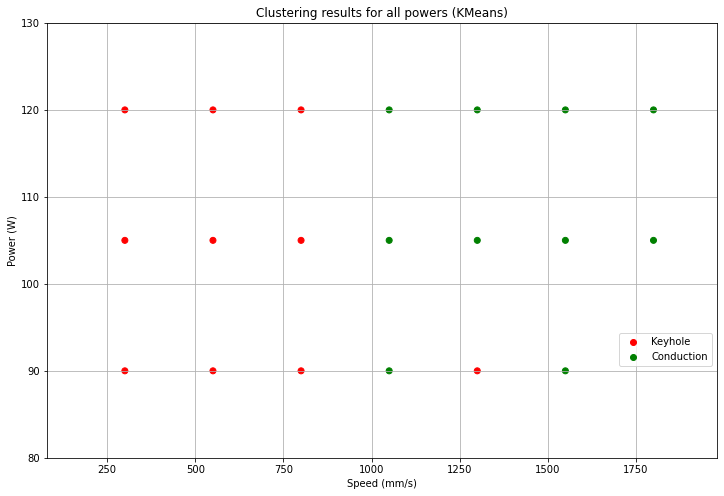

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


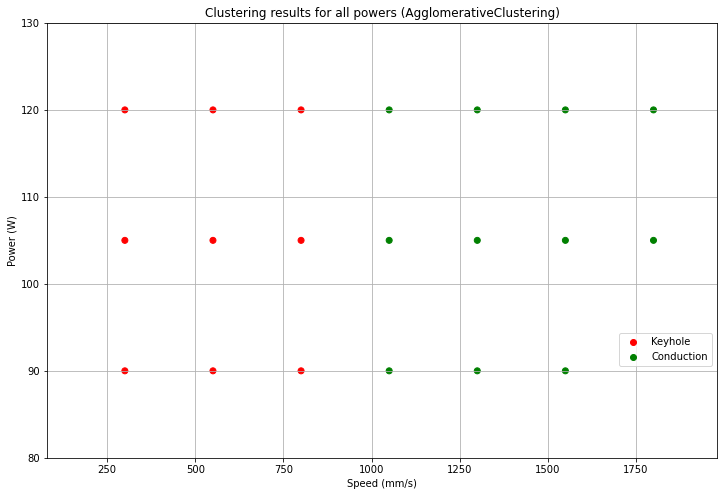

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


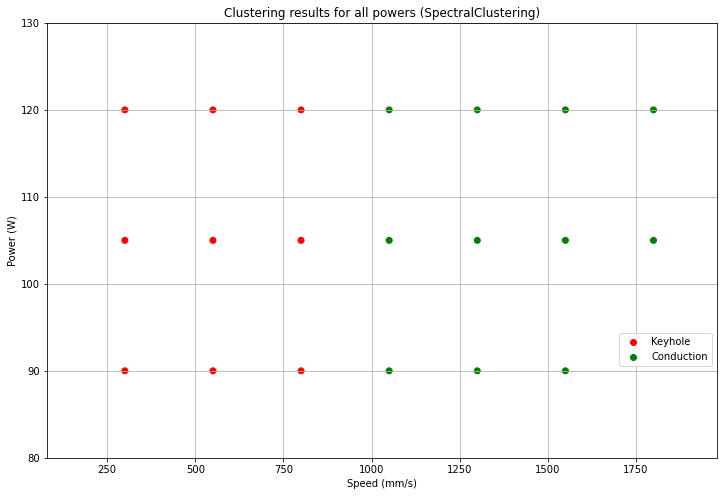

In [3]:
clustering_and_plotting('./Data/Neuchatel_316L/', [3, 4])


Working on cube 5
Condition 1: Found 10 segments, Avg. Size: 1533.20, Std. Dev: 9.43
Segment Max Size: 1538, Segment Min Size: 1505
Condition 2: Found 10 segments, Avg. Size: 1289.00, Std. Dev: 0.77
Segment Max Size: 1291, Segment Min Size: 1288
Condition 3: Found 10 segments, Avg. Size: 1110.20, Std. Dev: 1.08
Segment Max Size: 1112, Segment Min Size: 1108
Condition 4: Found 10 segments, Avg. Size: 6693.90, Std. Dev: 15.47
Segment Max Size: 6725, Segment Min Size: 6674
Condition 5: Found 11 segments, Avg. Size: 1262.18, Std. Dev: 94.32
Segment Max Size: 1317, Segment Min Size: 965
Condition 6: Found 11 segments, Avg. Size: 1290.18, Std. Dev: 0.72
Segment Max Size: 1292, Segment Min Size: 1289
Condition 7: Found 10 segments, Avg. Size: 1903.20, Std. Dev: 0.75
Segment Max Size: 1904, Segment Min Size: 1902
Condition 8: Found 10 segments, Avg. Size: 2500.30, Std. Dev: 3.49
Segment Max Size: 2507, Segment Min Size: 2498
Condition 9: Found 10 segments, Avg. Size: 1538.60, Std. Dev: 2.11
Se

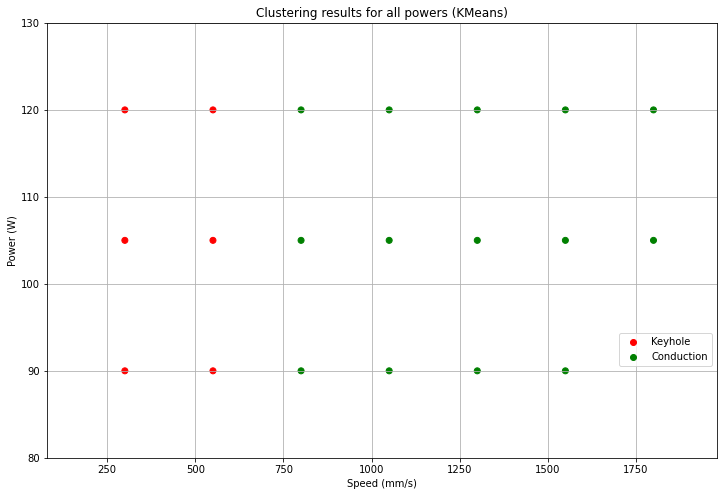

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


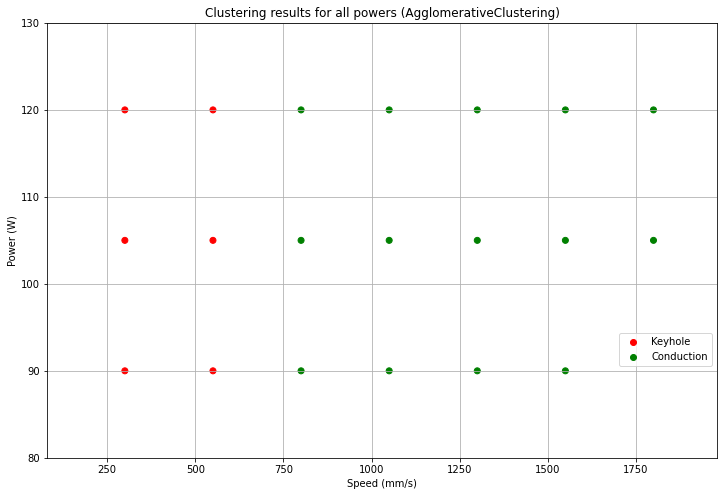

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


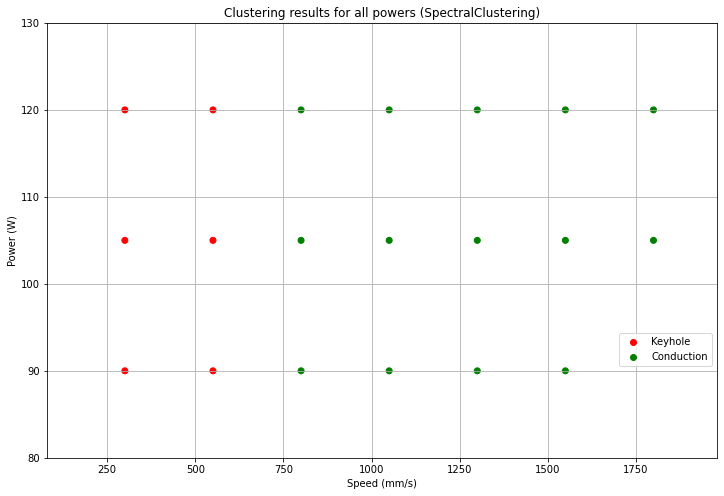

In [4]:
clustering_and_plotting('./Data/Neuchatel_316L/', [5, 6])


Working on cube 7
Condition 1: Found 10 segments, Avg. Size: 6713.90, Std. Dev: 38.66
Segment Max Size: 6785, Segment Min Size: 6674
Condition 2: Found 10 segments, Avg. Size: 1216.80, Std. Dev: 1.33
Segment Max Size: 1219, Segment Min Size: 1215
Condition 3: Found 10 segments, Avg. Size: 1349.10, Std. Dev: 5.37
Segment Max Size: 1363, Segment Min Size: 1344
Condition 4: Found 10 segments, Avg. Size: 5350.20, Std. Dev: 63.08
Segment Max Size: 5469, Segment Min Size: 5284
Condition 5: Found 10 segments, Avg. Size: 2148.50, Std. Dev: 9.91
Segment Max Size: 2178, Segment Min Size: 2143
Condition 6: Found 10 segments, Avg. Size: 2880.10, Std. Dev: 4.28
Segment Max Size: 2889, Segment Min Size: 2876
Condition 7: Found 10 segments, Avg. Size: 1713.50, Std. Dev: 3.56
Segment Max Size: 1723, Segment Min Size: 1711
Condition 8: Found 10 segments, Avg. Size: 3745.70, Std. Dev: 18.55
Segment Max Size: 3793, Segment Min Size: 3727
Condition 9: Found 10 segments, Avg. Size: 1163.00, Std. Dev: 1.95


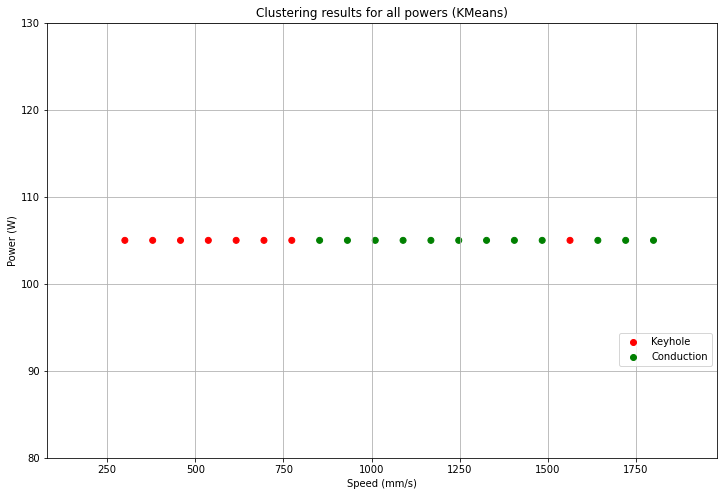

Working with data index 0 for algorithm AgglomerativeClustering


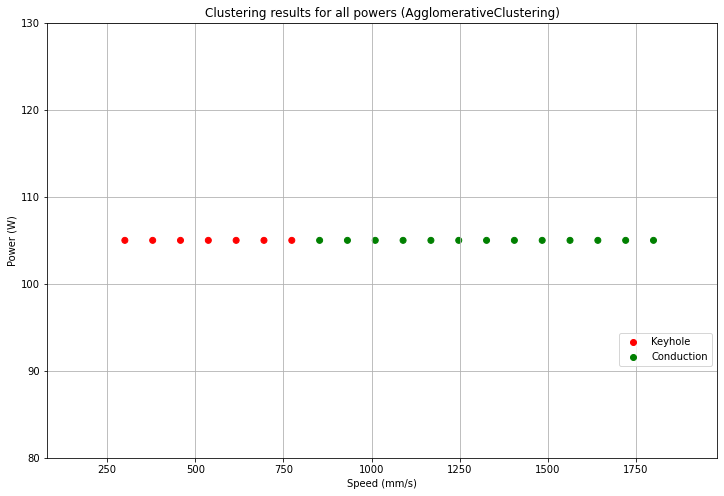

Working with data index 0 for algorithm SpectralClustering


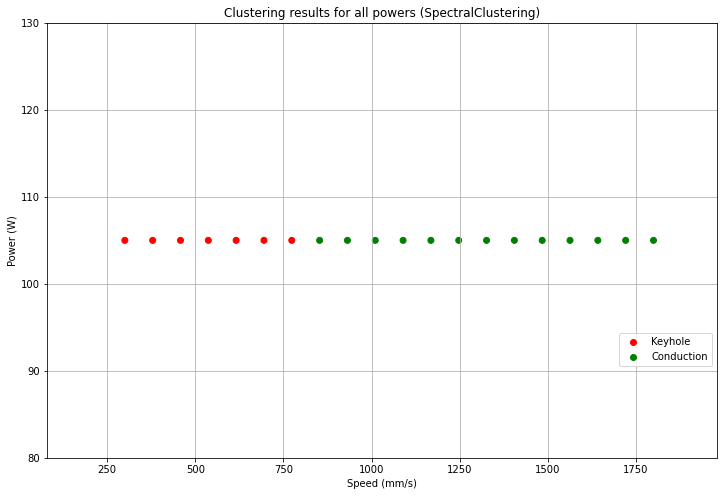

In [5]:
clustering_and_plotting('./Data/Neuchatel_316L/', [7, 8])


Working on cube 1
Condition 1: Found 7 segments, Avg. Size: 2330.71, Std. Dev: 59.98
Segment Max Size: 2439, Segment Min Size: 2258
Condition 2: Found 8 segments, Avg. Size: 3518.62, Std. Dev: 747.49
Segment Max Size: 5370, Segment Min Size: 2962
Condition 3: Found 10 segments, Avg. Size: 1471.00, Std. Dev: 176.31
Segment Max Size: 1632, Segment Min Size: 961
Condition 4: Found 6 segments, Avg. Size: 2005.33, Std. Dev: 79.02
Segment Max Size: 2158, Segment Min Size: 1917
Condition 5: Found 10 segments, Avg. Size: 3947.00, Std. Dev: 112.14
Segment Max Size: 4219, Segment Min Size: 3838
Condition 6: Found 10 segments, Avg. Size: 2846.50, Std. Dev: 186.12
Segment Max Size: 3382, Segment Min Size: 2731
Condition 7: Found 10 segments, Avg. Size: 1753.00, Std. Dev: 91.77
Segment Max Size: 1929, Segment Min Size: 1609
Condition 8: Found 10 segments, Avg. Size: 2076.60, Std. Dev: 96.59
Segment Max Size: 2300, Segment Min Size: 1991
Condition 9: Found 10 segments, Avg. Size: 1525.10, Std. Dev: 

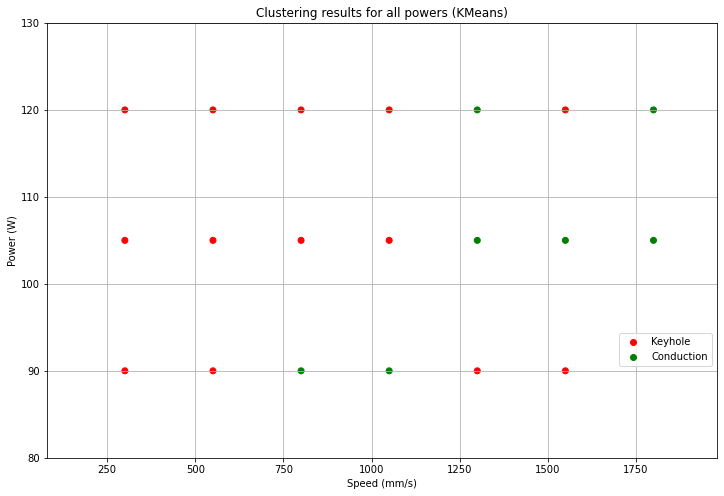

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


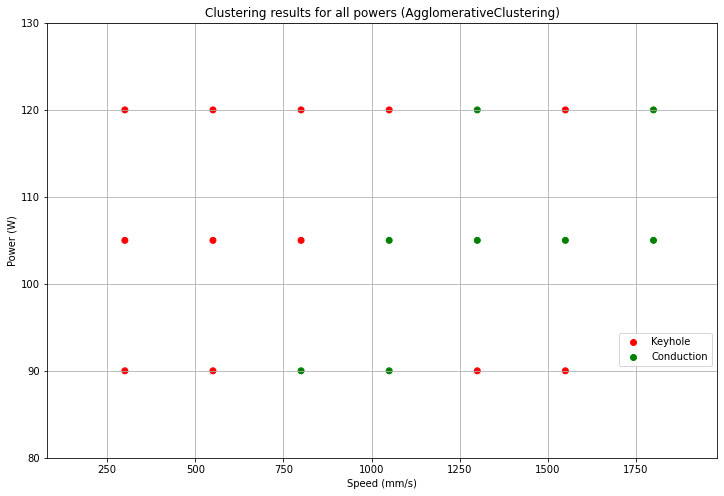

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


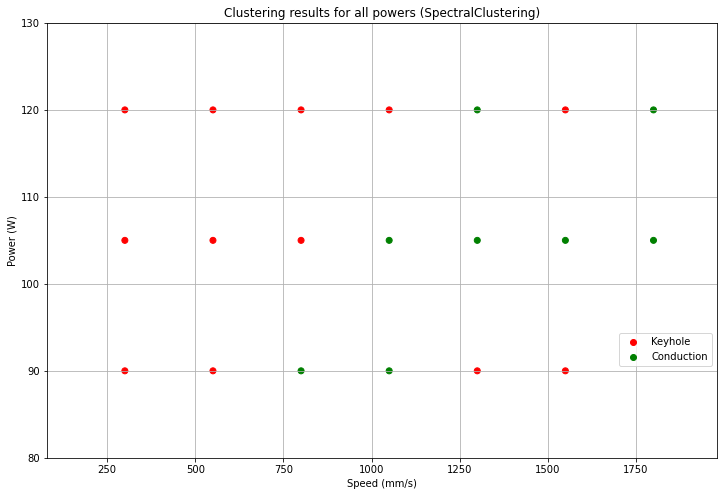

In [6]:
clustering_and_plotting('./Data/Neuchatel_Ti64/', [1, 2])


Working on cube 3
Condition 1: Found 10 segments, Avg. Size: 1494.60, Std. Dev: 80.27
Segment Max Size: 1629, Segment Min Size: 1398
Condition 2: Found 10 segments, Avg. Size: 1671.30, Std. Dev: 59.68
Segment Max Size: 1825, Segment Min Size: 1621
Condition 3: Found 10 segments, Avg. Size: 2261.10, Std. Dev: 303.93
Segment Max Size: 3051, Segment Min Size: 2039
Condition 4: Found 10 segments, Avg. Size: 7092.60, Std. Dev: 124.69
Segment Max Size: 7407, Segment Min Size: 6922
Condition 5: Found 10 segments, Avg. Size: 3915.20, Std. Dev: 69.11
Segment Max Size: 4077, Segment Min Size: 3857
Condition 6: Found 10 segments, Avg. Size: 2073.60, Std. Dev: 71.71
Segment Max Size: 2228, Segment Min Size: 2000
Condition 7: Found 10 segments, Avg. Size: 1262.60, Std. Dev: 115.61
Segment Max Size: 1514, Segment Min Size: 1176
Condition 8: Found 10 segments, Avg. Size: 7133.70, Std. Dev: 122.16
Segment Max Size: 7416, Segment Min Size: 6959
Condition 9: Found 10 segments, Avg. Size: 2782.30, Std. D

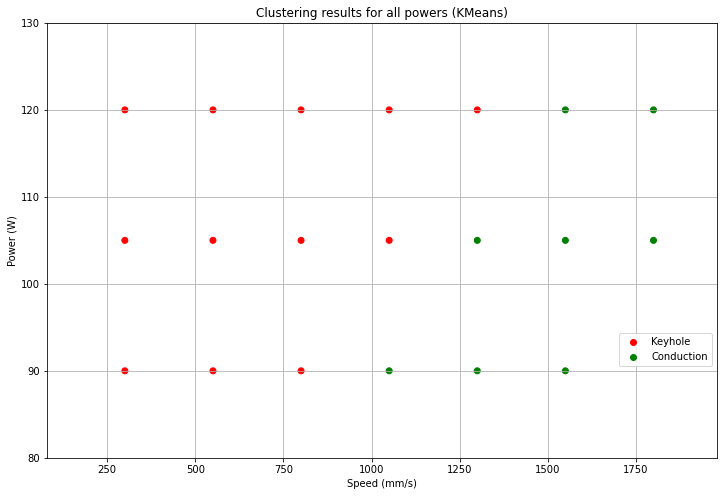

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


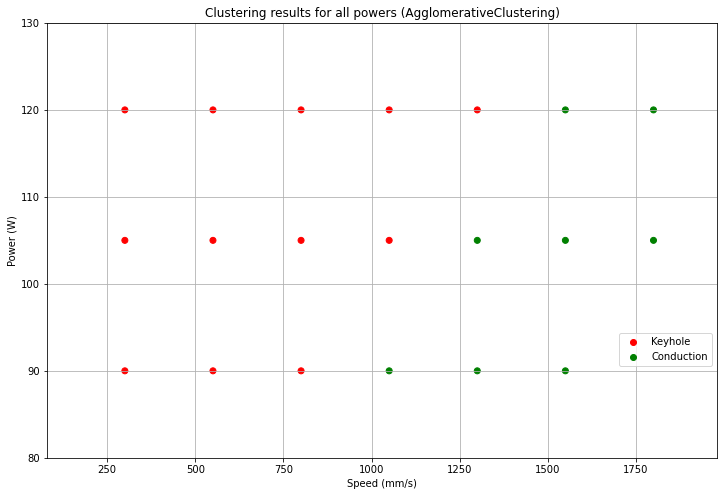

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


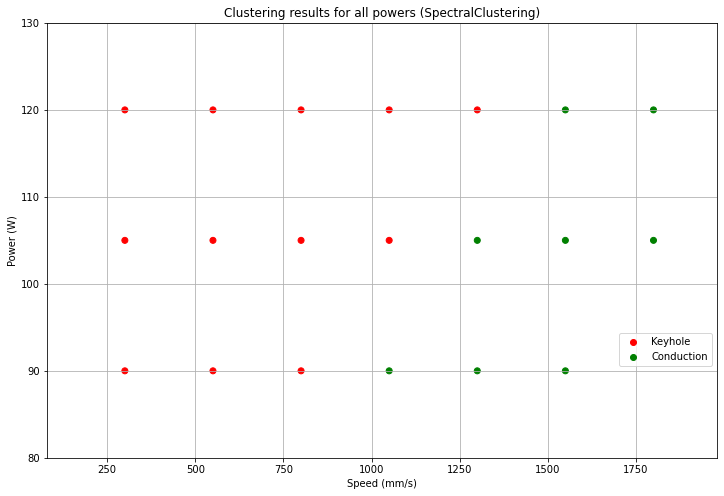

In [7]:
clustering_and_plotting('./Data/Neuchatel_Ti64/', [3, 4])


Working on cube 5
Condition 1: Found 10 segments, Avg. Size: 1845.50, Std. Dev: 171.94
Segment Max Size: 2204, Segment Min Size: 1648
Condition 2: Found 10 segments, Avg. Size: 1438.20, Std. Dev: 68.39
Segment Max Size: 1582, Segment Min Size: 1360
Condition 3: Found 10 segments, Avg. Size: 1272.90, Std. Dev: 121.21
Segment Max Size: 1590, Segment Min Size: 1156
Condition 4: Found 10 segments, Avg. Size: 7089.10, Std. Dev: 83.80
Segment Max Size: 7265, Segment Min Size: 6986
Condition 5: Found 11 segments, Avg. Size: 1525.36, Std. Dev: 193.70
Segment Max Size: 1773, Segment Min Size: 1108
Condition 6: Found 11 segments, Avg. Size: 1447.36, Std. Dev: 121.63
Segment Max Size: 1715, Segment Min Size: 1354
Condition 7: Found 10 segments, Avg. Size: 2109.10, Std. Dev: 87.63
Segment Max Size: 2256, Segment Min Size: 2025
Condition 8: Found 10 segments, Avg. Size: 2849.10, Std. Dev: 99.22
Segment Max Size: 3003, Segment Min Size: 2709
Condition 9: Found 10 segments, Avg. Size: 1705.90, Std. D

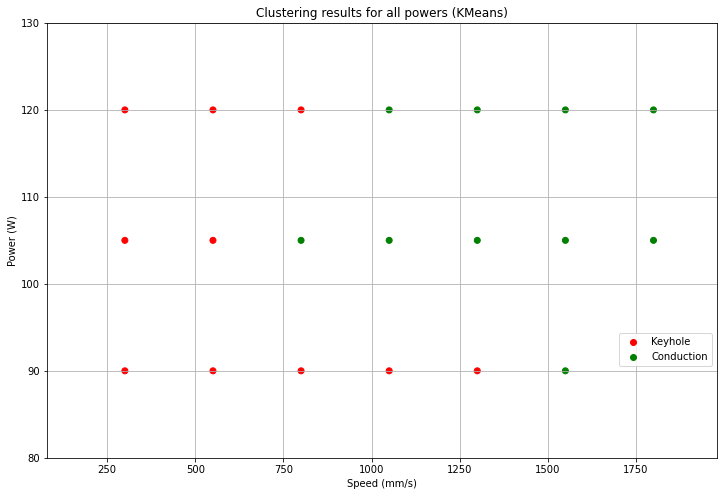

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


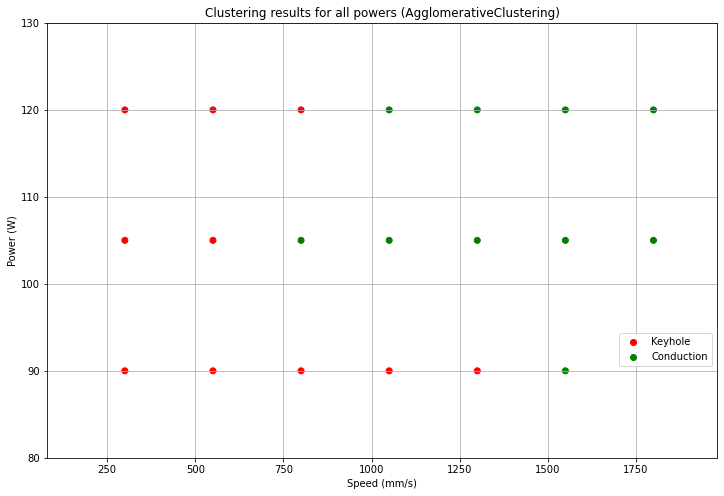

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


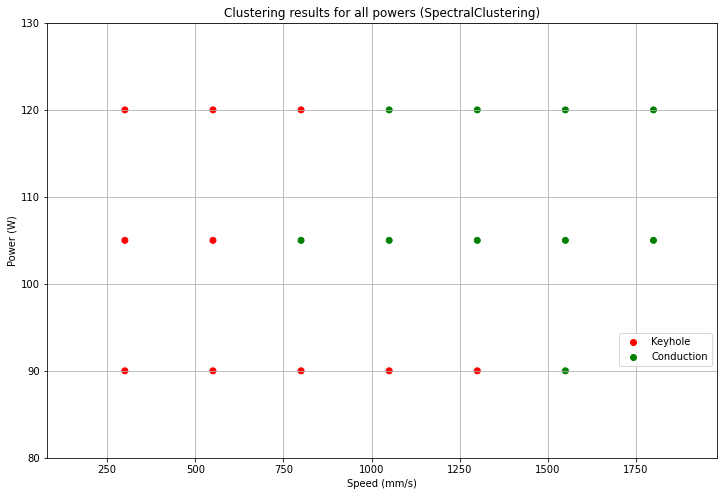

In [8]:
clustering_and_plotting('./Data/Neuchatel_Ti64/', [5, 6])


Working on cube 7
Condition 1: Found 10 segments, Avg. Size: 7066.10, Std. Dev: 143.05
Segment Max Size: 7342, Segment Min Size: 6928
Condition 2: Found 10 segments, Avg. Size: 1289.10, Std. Dev: 22.58
Segment Max Size: 1340, Segment Min Size: 1260
Condition 3: Found 10 segments, Avg. Size: 1436.30, Std. Dev: 30.26
Segment Max Size: 1501, Segment Min Size: 1402
Condition 4: Found 10 segments, Avg. Size: 5682.30, Std. Dev: 157.00
Segment Max Size: 6020, Segment Min Size: 5548
Condition 5: Found 10 segments, Avg. Size: 2279.10, Std. Dev: 37.93
Segment Max Size: 2350, Segment Min Size: 2233
Condition 6: Found 10 segments, Avg. Size: 3156.30, Std. Dev: 108.09
Segment Max Size: 3342, Segment Min Size: 3043
Condition 7: Found 10 segments, Avg. Size: 1891.70, Std. Dev: 205.49
Segment Max Size: 2494, Segment Min Size: 1778
Condition 8: Found 10 segments, Avg. Size: 4083.80, Std. Dev: 108.79
Segment Max Size: 4330, Segment Min Size: 3946
Condition 9: Found 10 segments, Avg. Size: 1343.90, Std. 

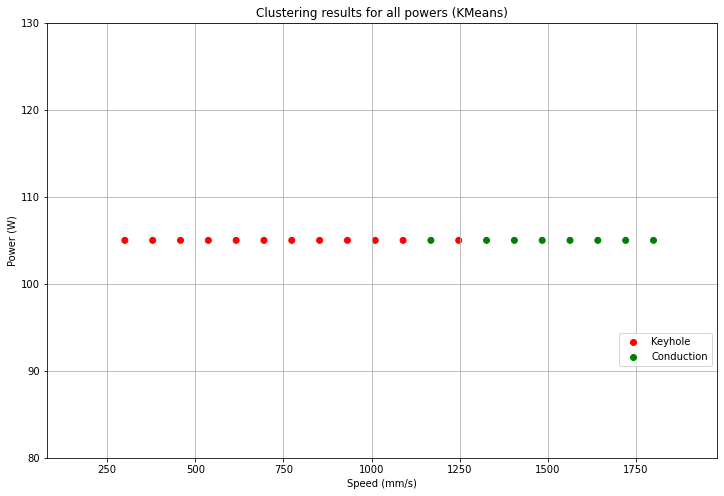

Working with data index 0 for algorithm AgglomerativeClustering


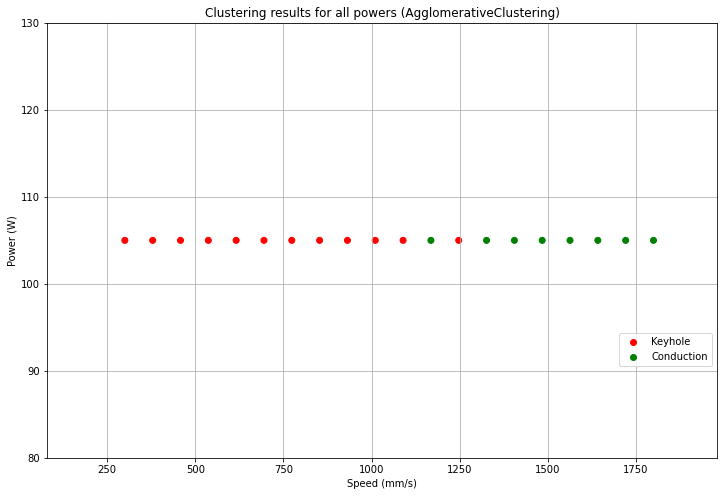

Working with data index 0 for algorithm SpectralClustering


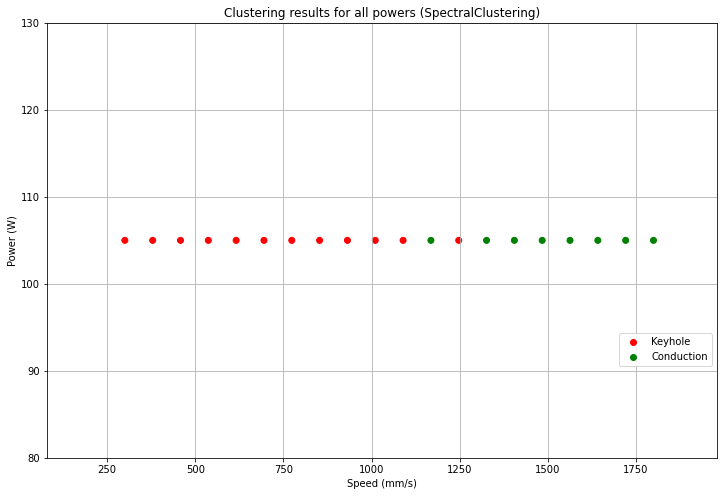

In [9]:
clustering_and_plotting('./Data/Neuchatel_Ti64/', [7, 8])
